# 파트 2: 다중 지식 소스

파트 1에서는 단일 지식 소스를 쿼리했습니다. 파트 2에서는 단일 지식 베이스에서 여러 지식 소스(HR + 건강 문서)를 쿼리하도록 확장합니다. 어떤 소스가 쿼리되는지 제어하고 자연어 지침을 사용하여 지식 베이스의 에이전틱 동작을 안내하는 방법을 배웁니다.

## 단계 1: 환경 변수 로드

아래 셀을 실행하여 Azure 리소스의 구성을 로드하고, 생성된 **.venv(3.11.9)** 환경을 선택하세요.

이번에는 지식 베이스 이름이 여러 소스를 사용한다는 것을 반영합니다: `hr-and-health-docs-knowledge-base`.

> **⚠️ 문제 해결**
>
> 코드 셀이 멈추고 계속 돌아가면 노트북 상단 툴바에서 **Restart**를 선택하세요. 몇 번 시도해도 문제가 지속되면 VS Code를 완전히 닫고 다시 여세요.

In [1]:
import os

from azure.core.credentials import AzureKeyCredential
from dotenv import load_dotenv

load_dotenv(override=True) # take environment variables from .env.

# Azure AI Search configuration
endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"])

# Knowledge base name
knowledge_base_name = "hr-and-health-docs-knowledge-base"

# Azure OpenAI configuration
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
azure_openai_key = os.environ["AZURE_OPENAI_KEY"]
azure_openai_chatgpt_deployment = os.getenv("AZURE_OPENAI_CHATGPT_DEPLOYMENT", "gpt-4.1")
azure_openai_chatgpt_model_name = os.getenv("AZURE_OPENAI_CHATGPT_MODEL_NAME", "gpt-4.1")

print("Environment variables loaded")

Environment variables loaded


## 단계 2: 두 개의 지식 소스 생성

두 개의 지식 소스를 생성합니다:
- **healthdocs-knowledge-source**: `healthdocs` 인덱스를 가리킴 (건강 혜택 및 보험에 관한 334개의 문서 청크)
- **hrdocs-knowledge-source**: `hrdocs` 인덱스를 가리킴 (HR 정책에 관한 50개의 문서 청크)

두 소스 모두 다른 인덱스에 연결되지만 동일한 필드 구성을 사용합니다 (인용을 위한 `blob_path`, 콘텐츠를 위한 `snippet`).

여러 지식 소스를 생성하면 지식 베이스가 사용자의 질문에 따라 어떤 데이터를 쿼리할지 지능적으로 결정할 수 있습니다.

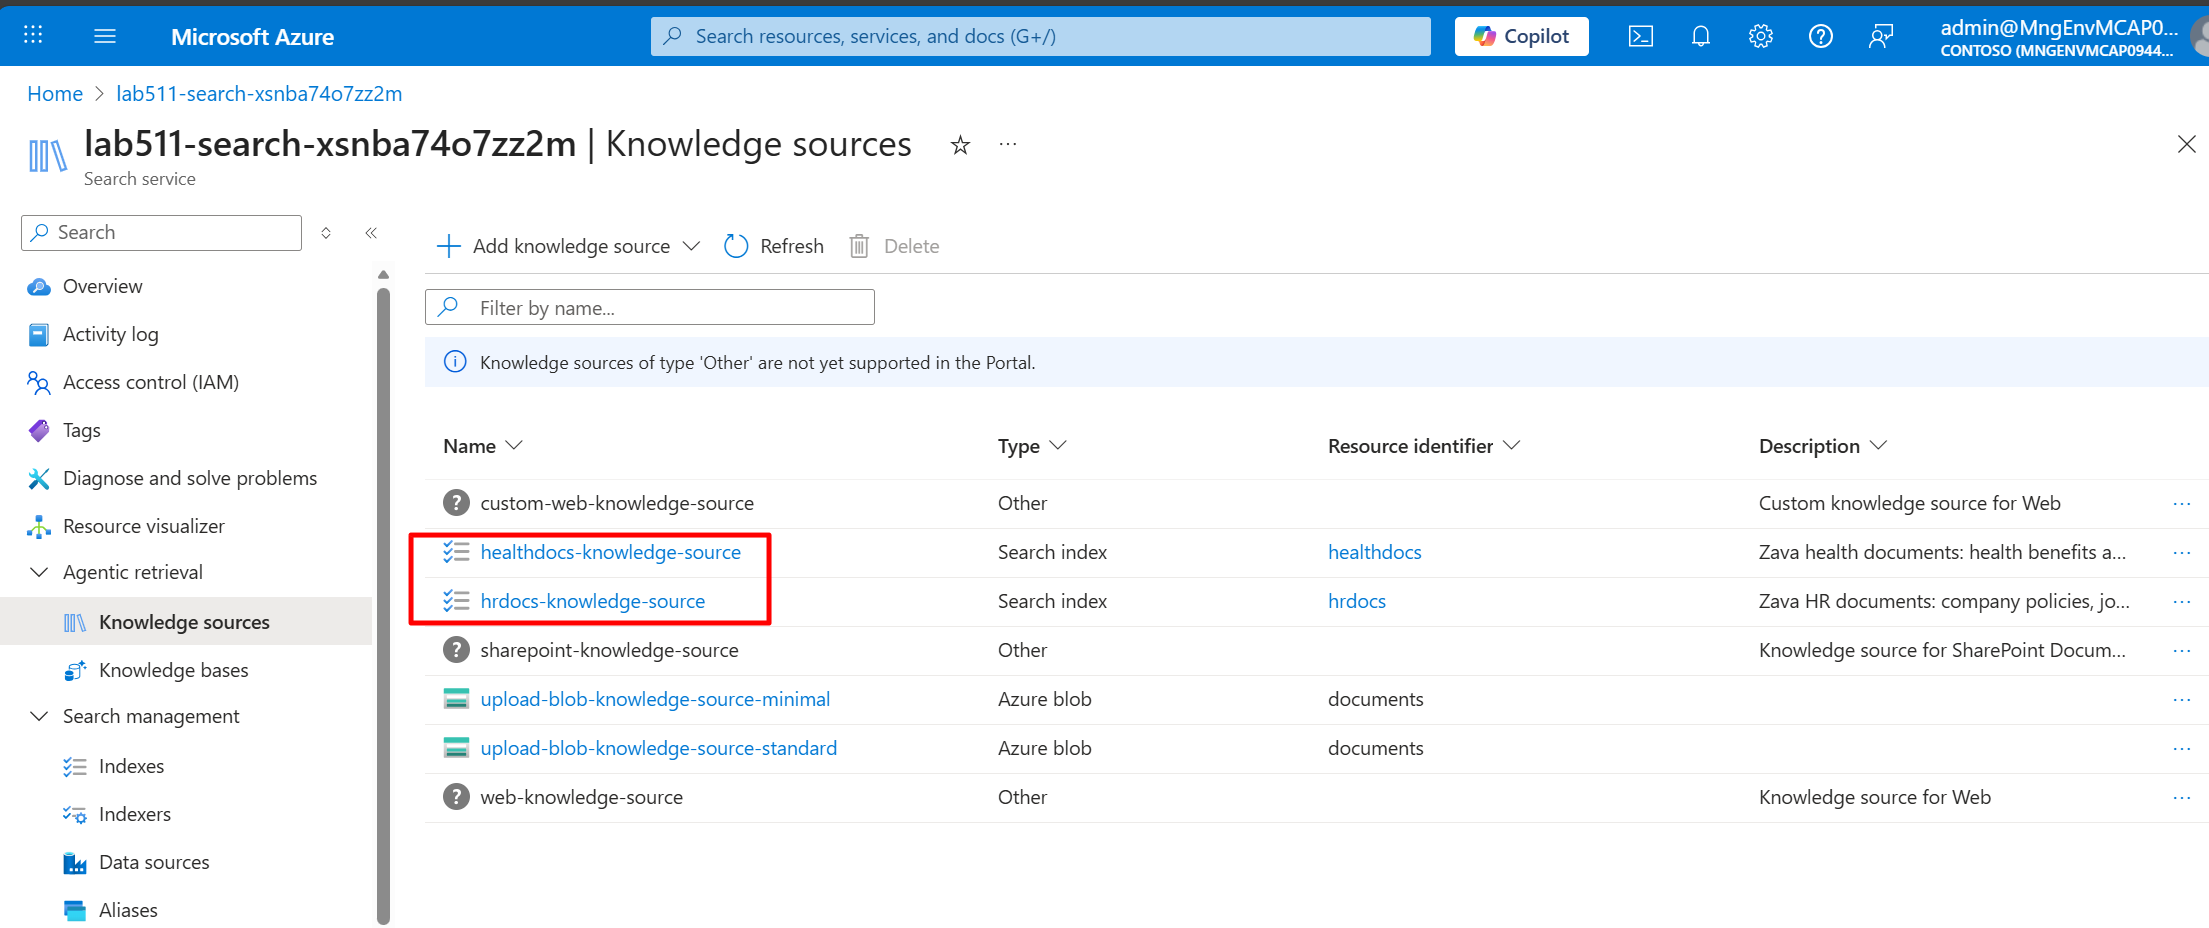

In [2]:
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import SearchIndexFieldReference, SearchIndexKnowledgeSource, SearchIndexKnowledgeSourceParameters

index_client = SearchIndexClient(endpoint=endpoint, credential=credential)

ks = SearchIndexKnowledgeSource(
    name="healthdocs-knowledge-source",
    description="Zava health documents: health benefits and insurance plan information",
    search_index_parameters=SearchIndexKnowledgeSourceParameters(
        search_index_name="healthdocs",
        source_data_fields=[SearchIndexFieldReference(name="blob_path"), SearchIndexFieldReference(name="snippet")],
        search_fields=[SearchIndexFieldReference(name="snippet")]
    ),
)
index_client.create_or_update_knowledge_source(knowledge_source=ks)
print(f"Knowledge source '{ks.name}' created or updated successfully.")

ks = SearchIndexKnowledgeSource(
    name="hrdocs-knowledge-source",
    description="Zava HR documents: company policies, job roles, workplace guidelines, and general benefits",
    search_index_parameters=SearchIndexKnowledgeSourceParameters(
        search_index_name="hrdocs",
        source_data_fields=[SearchIndexFieldReference(name="blob_path"), SearchIndexFieldReference(name="snippet")],
        search_fields=[SearchIndexFieldReference(name="snippet")]
    )
)

index_client.create_or_update_knowledge_source(knowledge_source=ks)
print(f"Knowledge source '{ks.name}' created or updated successfully.")

Knowledge source 'healthdocs-knowledge-source' created or updated successfully.
Knowledge source 'hrdocs-knowledge-source' created or updated successfully.
Knowledge source 'hrdocs-knowledge-source' created or updated successfully.


## 단계 3: 결합된 지식 베이스 생성

이제 두 지식 소스를 모두 참조하는 지식 베이스를 생성합니다. `knowledge_sources` 매개변수가 참조 목록을 받는 것을 확인하세요.

이 단일 지식 베이스는 이제 HR과 건강 문서를 모두 쿼리할 수 있습니다. 쿼리를 보내면 지식 베이스가 질문을 분석하여 어떤 소스가 관련 있는지 결정하며, 하나의 소스, 두 소스 모두, 또는 질문 내용에 따라 지능적으로 선택할 수 있습니다.

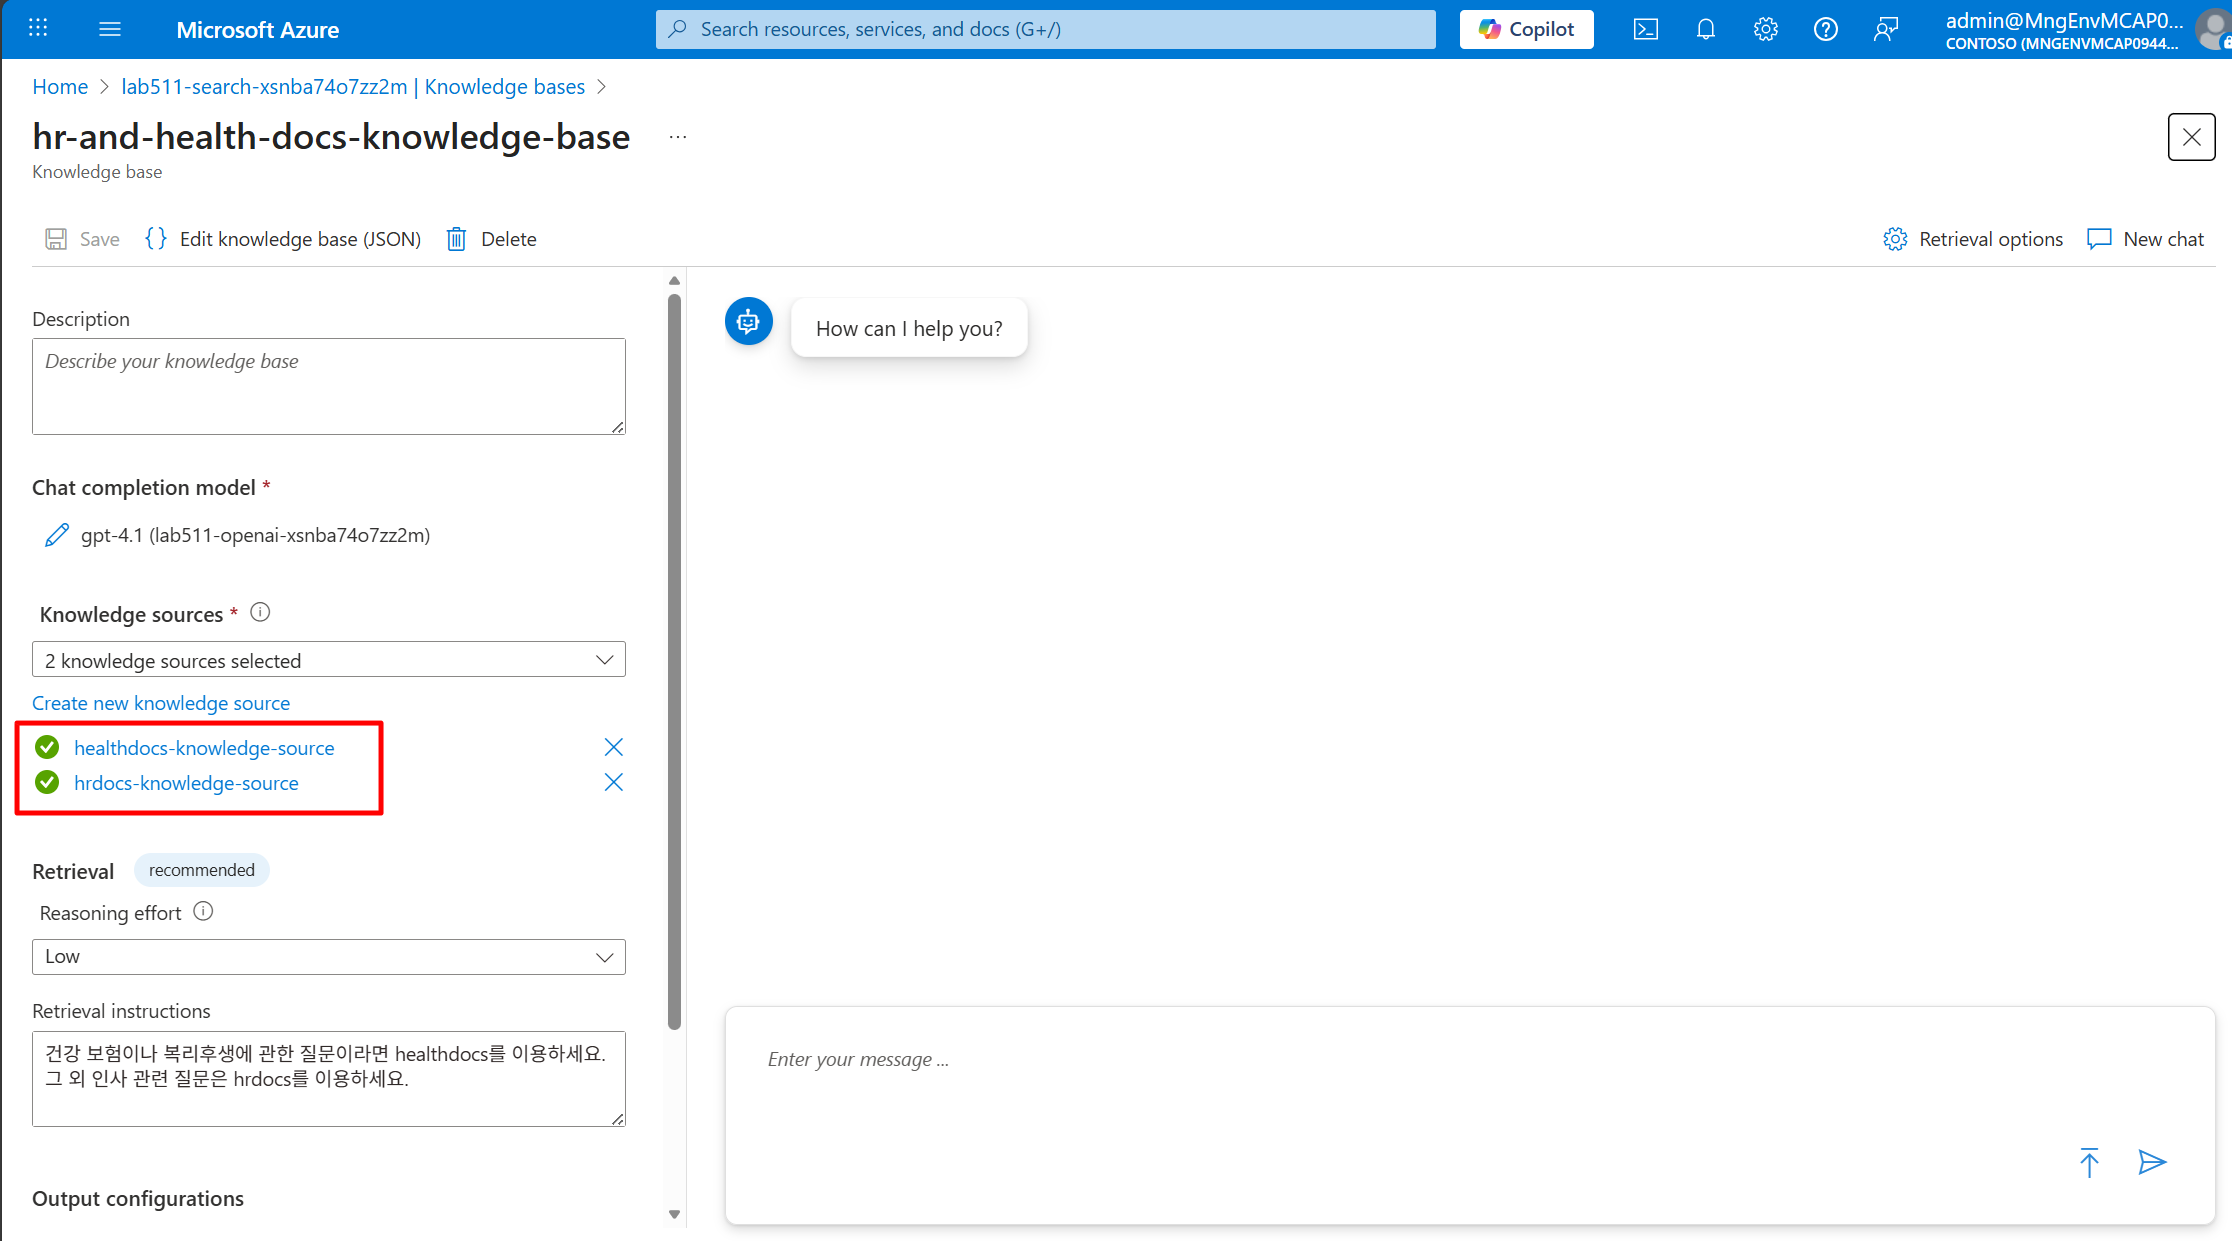

In [3]:
from azure.search.documents.indexes.models import AzureOpenAIVectorizerParameters, KnowledgeBase, KnowledgeBaseAzureOpenAIModel, KnowledgeRetrievalOutputMode, KnowledgeSourceReference

aoai_params = AzureOpenAIVectorizerParameters(
    resource_url=azure_openai_endpoint,
    deployment_name=azure_openai_chatgpt_deployment,
    model_name=azure_openai_chatgpt_model_name,
    api_key=azure_openai_key
)

knowledge_base = KnowledgeBase(
    name=knowledge_base_name,
    models=[KnowledgeBaseAzureOpenAIModel(azure_open_ai_parameters=aoai_params)],
    knowledge_sources=[
        KnowledgeSourceReference(name="healthdocs-knowledge-source"),
        KnowledgeSourceReference(name="hrdocs-knowledge-source")
    ],
    output_mode=KnowledgeRetrievalOutputMode.ANSWER_SYNTHESIS
)

index_client.create_or_update_knowledge_base(knowledge_base)
print(f"Knowledge base '{knowledge_base_name}' created or updated successfully.")

Knowledge base 'hr-and-health-docs-knowledge-base' created or updated successfully.


## 단계 4: 다중 소스 쿼리

하나의 쿼리에서 두 가지 질문을 해봅시다:
- "Zava CEO의 책임은 무엇인가요?" (HR 관련)
- "정신 건강 서비스에 대한 최상의 보장을 원한다면 어떤 건강 보험 플랜을 추천하시겠습니까?" (건강 관련)

이 쿼리를 실행하면 지식 베이스가 에이전틱 검색을 사용합니다:
1. 쿼리를 분석하여 두 가지 다른 주제에 대해 묻고 있음을 이해
2. 쿼리를 집중된 하위 쿼리로 분해 (쿼리의 각 하위 주제에 대해 하나씩)
3. 각 하위 쿼리에 관련 있는 지식 소스 결정
4. 선택된 소스에 대해 동시에 검색 실행
5. 시맨틱 랭커를 사용하여 결과 재순위 및 필터링
6. 두 소스에서 일관된 답변 합성

기본적으로 지식 베이스는 쿼리할 소스를 지능적으로 선택합니다. 관련 있다고 판단하는 소스만 쿼리할 수 있으며, 이를 다음 단계에서 확인합니다.

In [4]:
from azure.search.documents.knowledgebases import KnowledgeBaseRetrievalClient
from azure.search.documents.knowledgebases.models import KnowledgeBaseMessage, KnowledgeBaseMessageTextContent, KnowledgeBaseRetrievalRequest, SearchIndexKnowledgeSourceParams
from IPython.display import display, Markdown

knowledge_base_client = KnowledgeBaseRetrievalClient(endpoint=endpoint, knowledge_base_name=knowledge_base_name, credential=credential)

healthdocs_ks_params = SearchIndexKnowledgeSourceParams(
    knowledge_source_name="healthdocs-knowledge-source",
    include_references=True,
    include_reference_source_data=True
)
hrdocs_ks_params = SearchIndexKnowledgeSourceParams(
    knowledge_source_name="hrdocs-knowledge-source",
    include_references=True,
    include_reference_source_data=True
)
req = KnowledgeBaseRetrievalRequest(
    messages=[
        KnowledgeBaseMessage(role="user", content=[KnowledgeBaseMessageTextContent(text="""
            Zava CEO의 책임은 무엇인가요?
            정신 건강 서비스에 대한 최상의 보장을 원한다면 어떤 건강 보험 플랜을 추천하시겠습니까?
        """)])
    ],
    knowledge_source_params=[
        healthdocs_ks_params,
        hrdocs_ks_params
    ],
    include_activity=True
)

result = knowledge_base_client.retrieve(retrieval_request=req)
display(Markdown(result.response[0].content[0].text))

Zava의 CEO는 회사의 전략적 방향과 감독을 제공하여 장기적인 성공과 수익성을 보장하는 역할을 맡고 있습니다. 주요 책임에는 회사의 재무적 성공과 장기 성장을 위한 전략 및 목표 개발 및 실행, 임원팀에 대한 전략적 지도와 방향 제공, 회사의 일상 운영 관리, 모든 법률 및 규정 준수 보장, 마케팅 및 광고 전략 개발 감독, 주요 이해관계자와의 관계 관리, 대외 행사에서 회사 대표, 공급업체와의 계약 관리 및 협상, 업계 동향 모니터링 및 성장 기회 발굴, 긍정적인 기업 문화 조성 등이 포함됩니다[ref_id:2].

정신 건강 서비스에 대한 최상의 보장을 원한다면 Northwind Health Plus 플랜을 추천할 수 있습니다. 이 플랜은 의료, 시력, 치과 서비스뿐만 아니라 처방약, 정신 건강 및 약물 남용 서비스, 예방 진료까지 포괄적으로 보장합니다. 특히 정신 건강 및 약물 남용 서비스는 의료 및 외과적 혜택과 동등하게 제공되어야 하며, 입원 및 외래 서비스, 약물 관리, 심리 및 사회적 치료 등이 포함됩니다. 또한 관련 법률 및 규정을 준수해야 하며, 차별 없이 서비스를 제공해야 합니다[ref_id:1][ref_id:5][ref_id:7].

## 단계 5: 인용을 지식 소스에 매핑

이 헬퍼 함수는 답변의 각 인용을 원래 지식 소스로 추적합니다. 정보가 `hrdocs`에서 왔는지 `healthdocs`에서 왔는지 보여줍니다.

이 함수를 사용하여 지식 베이스가 어떤 소스를 선택했는지 확인하고, 정보 출처를 검증하며, 다른 질문 유형에 대해 올바른 소스를 선택하는지 확인할 수 있습니다.

아래 셀을 실행하여 각 인용이 어떤 지식 소스에서 왔는지 확인하세요.

In [5]:
import re


def find_source_of_reference(reference_id):
    activity_id = None
    for reference in result.references:
        if reference.id == reference_id:
            activity_id = reference.activity_source
            break
    for activity in result.activity:
        if activity.id == activity_id:
            return activity.knowledge_source_name
    return None

def cite_sources(text):
    references = re.findall(r'\[ref_id:(\d+)\]', text)
    sources = {}
    for ref_id in references:
        source_info = find_source_of_reference(ref_id)
        if source_info:
            sources[ref_id] = source_info
    
    return sources

sources = cite_sources(result.response[0].content[0].text)
print("Cited sources:", sources)


Cited sources: {'2': 'hrdocs-knowledge-source', '1': 'healthdocs-knowledge-source', '5': 'healthdocs-knowledge-source', '7': 'healthdocs-knowledge-source'}


## 단계 6: 모든 소스 강제 쿼리

두 지식 소스 매개변수에 `always_query_source=True`를 설정하면 지식 베이스가 관련 있다고 생각하든 상관없이 두 소스를 모두 쿼리하도록 강제할 수 있습니다.

아래 코드는 단일 간단한 질문을 실행합니다. 이번에는 `always_query_source=True`가 지능적 선택을 무시하기 때문에 두 소스 모두 쿼리됩니다. 하나가 꼭 필요하지 않은 경우에도 두 소스의 인용을 보게 되고, 두 소스에서 가져온 더 포괄적인 답변과 출력에서 다른 소스 매핑을 보게 됩니다.

이는 모든 데이터에서 포괄적인 범위를 원할 때 유용하지만, 지연 시간과 토큰 사용량이 더 높아지는 비용이 있습니다.

다른 질문으로 시도해보고 결과가 어떻게 달라지는지 확인해보세요!

In [ ]:
healthdocs_ks_params.always_query_source = True
hrdocs_ks_params.always_query_source = True

req = KnowledgeBaseRetrievalRequest(
    messages=[
        KnowledgeBaseMessage(role="user", content=[KnowledgeBaseMessageTextContent(text="건강 혜택은 무엇이 있나요?")])
    ],
    knowledge_source_params=[
        healthdocs_ks_params,
        hrdocs_ks_params
    ],
    include_activity=True
)

result = knowledge_base_client.retrieve(retrieval_request=req)
display(Markdown(result.response[0].content[0].text))

sources_cited = cite_sources(result.response[0].content[0].text)
print("Cited sources:", sources)

sources_queried = [activity.knowledge_source_name for activity in result.activity if activity.type == "searchIndex"]
print("Queried sources:", sources_queried)

다음과 같은 건강 혜택이 있습니다:

- Northwind Standard 플랜에서는 신체검사, 예방접종, 혈압·콜레스테롤·당뇨 검사 등 예방 진료 서비스가 추가 비용 없이 제공됩니다[ref_id:6][ref_id:0]. 또한, 영양 및 생활습관 상담, 시력 및 청력 검사 등도 포함됩니다[ref_id:6].
- 처방약 관리, 온라인 또는 전화로 처방전 재주문, 모바일 앱을 통한 처방전 관리가 가능합니다. 선호 약국을 이용하면 제네릭 의약품에 대한 할인 혜택도 받을 수 있습니다[ref_id:0].
- Northwind Health Plus 플랜에는 만성질환 관리 프로그램(CCMP)이 포함되어 있어, 의료진 팀이 맞춤형 관리와 교육, 약물 관리, 서비스 조정 등을 지원합니다[ref_id:8].
- 개인 건강 지원 프로그램, 질병 관리, 웰니스 프로그램(금연, 스트레스 관리 등)도 제공됩니다. 단, 일부 프로그램은 Northwind Health Plus 가입자만 이용할 수 있습니다[ref_id:10][ref_id:8].
- PerksPlus 프로그램을 통해 연간 최대 $1000까지 피트니스 관련 비용(헬스장, 요가, 운동기구, 스포츠팀 참가비, 건강 리트릿 등)을 지원받을 수 있습니다[ref_id:5][ref_id:1].

단, Northwind Standard 플랜은 응급 서비스, 정신 건강 및 약물 남용 서비스, 일부 비의료적 서비스(예: 미용 목적, FDA 미승인 약물 등)는 보장하지 않습니다[ref_id:4][ref_id:0].

Cited sources: {'2': 'hrdocs-knowledge-source', '1': 'healthdocs-knowledge-source', '5': 'healthdocs-knowledge-source', '7': 'healthdocs-knowledge-source'}
Queried sources: ['healthdocs-knowledge-source', 'healthdocs-knowledge-source', 'hrdocs-knowledge-source', 'hrdocs-knowledge-source']


## 단계 7: 검색 지침으로 소스 선택 안내

**검색 지침(retrieval_instructions)**을 사용하면 모든 것을 쿼리하도록 강제하는 대신 자연어를 사용하여 지식 베이스의 소스 선택을 안내할 수 있습니다.

`retrieval_instructions`를 설정하여 "건강 질문에는 healthdocs를, HR 질문에는 hrdocs를 사용하세요"와 같은 안내를 제공할 수 있습니다. 지식 베이스가 최종 결정을 내리지만, 이제 여러분의 안내가 있습니다. 더 나은 효율성을 위해 관련 없는 소스를 건너뛸 수 있고, `always_query_source=True`보다 의도를 더 잘 이해하기 위해 제공한 컨텍스트를 사용합니다.

아래 첫 번째 셀은 검색 지침으로 지식 베이스를 업데이트합니다.

두 번째 셀은 `always_query_source=False`로 쿼리하여 지침이 소스 선택을 어떻게 안내하는지 확인합니다.

In [11]:
knowledge_base.retrieval_instructions="건강 보험이나 복리후생에 관한 질문이라면 healthdocs를 이용하세요. 그 외 인사 관련 질문은 hrdocs를 이용하세요."

index_client.create_or_update_knowledge_base(knowledge_base)
print(f"Knowledge base '{knowledge_base_name}' created or updated successfully.")

Knowledge base 'hr-and-health-docs-knowledge-base' created or updated successfully.


In [12]:
healthdocs_ks_params.always_query_source = False
hrdocs_ks_params.always_query_source = False

req = KnowledgeBaseRetrievalRequest(
    messages=[
        KnowledgeBaseMessage(role="user", content=[KnowledgeBaseMessageTextContent(text="건강 혜택은 무엇이 있나요?")])
    ],
    knowledge_source_params=[
        healthdocs_ks_params,
        hrdocs_ks_params
    ],
    include_activity=True
)


result = knowledge_base_client.retrieve(retrieval_request=req)
display(Markdown(result.response[0].content[0].text))

sources_cited = cite_sources(result.response[0].content[0].text)
print("Cited sources:", sources)

sources_queried = [activity.knowledge_source_name for activity in result.activity if activity.type == "searchIndex"]
print("Queried sources:", sources_queried)

Zava 직원들을 위한 건강 혜택으로는 PerksPlus 건강 및 웰니스 프로그램이 있습니다. 이 프로그램을 통해 직원들은 연간 최대 $1,000까지 피트니스 관련 프로그램에 사용할 수 있습니다. PerksPlus는 체육관 회원권, 개인 트레이닝, 요가 및 필라테스 수업, 피트니스 장비 구입, 스포츠 팀 참가비, 건강 리트릿 및 스파, 등산·카약 등 야외 활동, 그룹 피트니스 수업(댄스, 무술, 사이클링 등), 온라인 피트니스 프로그램(온라인 요가 및 운동 수업 등)을 지원합니다. 또한 스키, 스노보드, 스쿠버다이빙, 서핑, 승마 등 다양한 레슨도 포함되어 있습니다. 단, 비피트니스 관련 비용, 의료 시술, 여행 경비(피트니스 프로그램과 관련 없는 경우), 음식 및 보충제 등은 지원되지 않습니다[ref_id:2][ref_id:4].

또한, 표준 휴가(2주)에는 건강 및 웰니스 지원금이 포함되어 있습니다[ref_id:1][ref_id:3].

Cited sources: {'2': 'hrdocs-knowledge-source', '1': 'healthdocs-knowledge-source', '5': 'healthdocs-knowledge-source', '7': 'healthdocs-knowledge-source'}
Queried sources: ['healthdocs-knowledge-source', 'hrdocs-knowledge-source']


## 단계 8: 답변 지침으로 답변 형식 지정

**답변 지침(answer_instructions)**은 지식 베이스가 응답을 어떻게 형식 지정하는지 제어합니다. 어떤 소스가 쿼리되거나 어떤 정보가 검색되는지는 변경하지 않고 - 단지 표시 방식만 변경합니다.

아래 코드는 `answer_instructions`를 사용하여 지식 베이스에 답변을 글머리 기호 목록으로 형식 지정하도록 지시합니다. 애플리케이션별 형식이 필요할 때마다 이 설정을 사용자 정의하고 싶을 것입니다.

아래 첫 번째 셀은 새로운 `answer_instructions`로 지식 베이스를 업데이트합니다. 두 번째 셀은 동일한 쿼리를 실행하여 형식화된 결과를 보여줍니다.

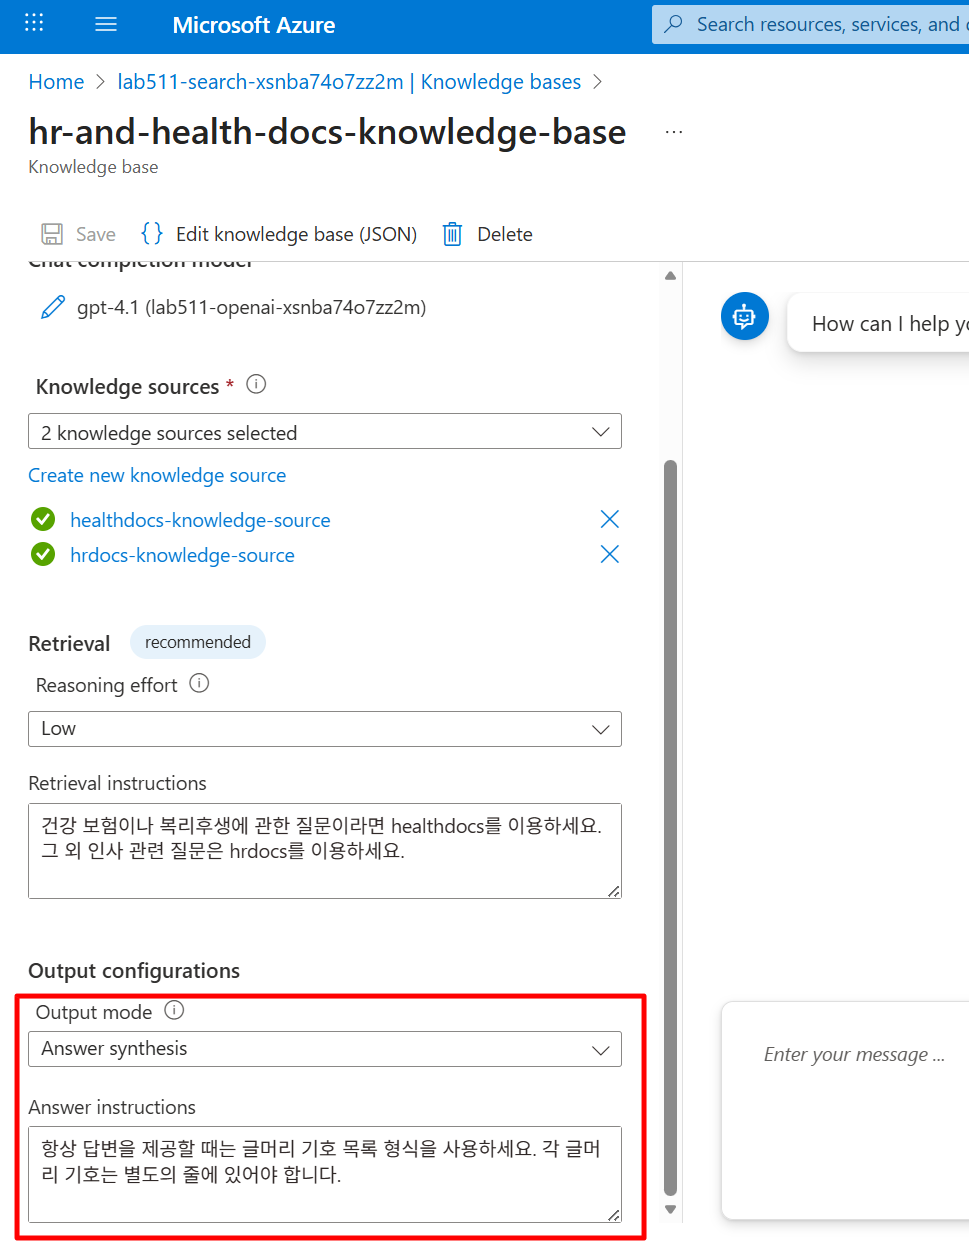

In [13]:
knowledge_base.answer_instructions="항상 답변을 제공할 때는 글머리 기호 목록 형식을 사용하세요. 각 글머리 기호는 별도의 줄에 있어야 합니다."

index_client.create_or_update_knowledge_base(knowledge_base)
print(f"Knowledge base '{knowledge_base_name}' created or updated successfully.")


Knowledge base 'hr-and-health-docs-knowledge-base' created or updated successfully.


In [14]:
result = knowledge_base_client.retrieve(retrieval_request=req)
display(Markdown(result.response[0].content[0].text))

• Northwind Standard 플랜에서는 예방 진료 서비스가 추가 비용 없이 제공됩니다[ref_id:0].
• 예방 진료에는 신체검사와 예방접종이 포함됩니다[ref_id:0].
• 혈압, 콜레스테롤, 당뇨병 검사 등 건강 검진 및 테스트가 포함됩니다[ref_id:0].
• 처방약 관리 및 리필을 온라인, 전화, 모바일 앱으로 요청할 수 있습니다[ref_id:0].
• 선호 약국을 이용하면 제네릭 의약품에 대한 할인 혜택을 받을 수 있습니다[ref_id:0].
• 일부 브랜드 의약품은 90일 또는 3개월 분량으로 추가 절약이 가능합니다[ref_id:0].
• 제네릭 의약품을 선택하면 비용을 절감할 수 있습니다[ref_id:0].
• Northwind Standard 플랜은 체중 감량제, 불임 치료제, 조제약, FDA 미승인 약품 등 일부 약품은 보장하지 않습니다[ref_id:0].
• 의사의 처방이 없는 일반의약품(OTC)은 보장되지 않으므로 직접 비용을 부담해야 합니다[ref_id:0].

## 요약

이제 단일 지식 베이스에서 여러 지식 소스를 사용하고 어떤 소스가 쿼리되는지 제어하는 방법을 배웠습니다.

**기억해야 할 핵심 개념:**
- 단일 지식 베이스는 여러 지식 소스를 참조할 수 있습니다
- 지식 베이스는 질문에 따라 쿼리할 소스를 지능적으로 선택합니다
- `always_query_source=True`는 모든 소스를 강제로 쿼리합니다
- `retrieval_instructions`는 자연어로 소스 선택을 안내합니다
- `answer_instructions`는 콘텐츠를 변경하지 않고 응답 형식을 제어합니다

### 다음 단계

➡️ [파트 3: SharePoint 지식 소스](part3-sharepoint-knowledge-source.ipynb)로 계속하여 지식 베이스를 SharePoint 문서 라이브러리에 직접 연결하는 방법을 배웁니다.